In [2]:
from transformers import pipeline
from langdetect import detect
from nltk.corpus import stopwords
import nltk, re, json, matplotlib.pyplot as plt
import librosa
import os

/home/santenana/miniconda3/envs/audio/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-04 11:29:25.416725: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-04 11:29:25.458382: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-04 11:29:26.315881: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slig

In [3]:
nltk.download('stopwords')

model_es_sentiment = "./models_text_sentiment/model_es_sentiment" 
model_en_sentiment = "./models_text_sentiment/model_en_sentiment"

model_es_toxic = "./models_text_sentiment/model_es_toxic"
model_en_toxic = "./models_text_sentiment/model_en_toxic"

sentiment_es = pipeline("sentiment-analysis", model=model_es_sentiment)
sentiment_en = pipeline("sentiment-analysis", model=model_en_sentiment)

toxic_es = pipeline("text-classification", model=model_es_toxic)
toxic_en = pipeline("text-classification", model=model_en_toxic)

stopwords_es = stopwords.words('spanish')
stopwords_en = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/santenana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


In [4]:
def groserias_espanol():
    archivos = os.listdir('./dataset')
    archivos
    groserias_list = []  
    for archivo in archivos:
        if 'txt' in archivo:
            with open(f'./dataset/{archivo}', 'r') as f:
                lineas = f.readlines()
                groserias  = [linea.strip() for linea in lineas ]
                for i in groserias:
                    groserias_list.append(i)
    return groserias_list


In [5]:
es = groserias_espanol()

        

In [6]:
polite_words = {
    "es": ["gracias", "por favor", "buen dia", "seria tan amable", "le agradezco", "disculpe", "permítame"],
    "en": ["please", "thank you", "good morning", "kindly", "appreciate", "sorry", "excuse me"]
}

rude_words = {
    "es": groserias_espanol(),
    "en": ["stupid", "idiot", "dumb", "useless", "shit", "terrible", "lazy"]
}

# Lista simple de términos técnicos (personalizable por dominio BPO)
technical_terms = {
    "es": ["sistema", "base de datos", "protocolo", "infraestructura", "algoritmo", "interfaz", "servidor"],
    "en": ["system", "database", "protocol", "infrastructure", "algorithm", "interface", "server"]
}

toxic_words = {
    "es": ["tonto", "idiota", "estúpido", "imbécil", "maldito", "horrible", "perezoso"],
    "en": ["stupid", "idiot", "dumb", "useless", "shit", "terrible", "lazy"]
}
# Las palabras toxicas se deben cambiar por palabras racistas, sexistas, etc.

In [7]:
def clean_text(text):
    return re.sub(r"[^a-zA-ZáéíóúüñÁÉÍÓÚÜÑ\s]", "", text).strip().lower()

In [8]:
def tone_analysis(text, lang):
    model = toxic_es if lang == "es" else toxic_en
    result = model(text)[0]

    # Mapear etiqueta a texto legible
    label_map = {
        "LABEL_0": "Neutral",
        "LABEL_1": "Ofensivo",
        "LABEL_2": "Muy ofensivo"
    }

    label = result.get("label", "LABEL_0")
    label_legible = label_map.get(label, label)
    score_toxic = result.get("score", 0.0) if "LABEL_0" not in label else 0.0

    polite_list = polite_words.get(lang, [])
    rude_list = rude_words.get(lang, [])

    polite_found = set()
    rude_found = set()

    for w in polite_list:
        if re.search(rf"\b{re.escape(w)}\b", text, re.IGNORECASE):
            polite_found.add(w)

    for w in rude_list:
        if re.search(rf"\b{re.escape(w)}\b", text, re.IGNORECASE):
            rude_found.add(w)

    score_polite = len(polite_found)
    score_rude = len(rude_found)

    tone_scores = {
        "Educado": score_polite * 0.6 + (1 - score_toxic) * 0.4,
        "Mal educado": score_rude * 0.5 + score_toxic * 0.3,
        "Agresivo": score_toxic * 0.7 + score_rude * 0.4
    }

    s = sum(tone_scores.values())
    for k in tone_scores:
        tone_scores[k] = tone_scores[k] / s if s > 0 else 0

    # Retornar resultado de toxicidad legible
    toxic_result = {
        "nivel": label_legible,
        "probabilidad": round(result.get("score", 0.0), 3)
    }

    return tone_scores, list(polite_found), list(rude_found), toxic_result

In [9]:
import re
import unicodedata

def normalize_text(text):
    text = unicodedata.normalize("NFD", text)
    text = "".join(c for c in text if unicodedata.category(c) != "Mn")
    return text.lower()

def language_complexity(text, lang):
    text = normalize_text(text)
    words = re.findall(r"\b\w+\b", text)

    if not words:
        return {"Simple": 1.0, "Técnico": 0.0}

    avg_len = sum(len(w) for w in words) / len(words)

    technical_terms_list = [normalize_text(t) for t in technical_terms.get(lang, [])]
    technical_count = 0

    for term in technical_terms_list:
        pattern = r"\b" + re.escape(term) + r"\b"
        if re.search(pattern, text, re.IGNORECASE):
            technical_count += 1

    proportion_technical = technical_count / len(words)

    if technical_count == 0:
        return {"Simple": 1.0, "Técnico": 0.0}

    simple_score = max(0, 1 - (avg_len / 6 + proportion_technical * 5))
    technical_score = 1 - simple_score

    return {"Simple": round(simple_score, 3), "Técnico": round(technical_score, 3)}

In [10]:
def language_toxic(text, lang):
    text = normalize_text(text)
    words = re.findall(r"\b\w+\b", text)

    if not words:
        return {"No tóxico": 1.0, "Tóxico": 0.0}

    toxic_terms_list = [normalize_text(t) for t in toxic_words.get(lang, [])]
    toxic_count = 0

    # Buscar coincidencias exactas de palabras tóxicas
    for term in toxic_terms_list:
        pattern = r"\b" + re.escape(term) + r"\b"
        if re.search(pattern, text, re.IGNORECASE):
            toxic_count += 1

    proportion_toxic = toxic_count / len(words)

    if toxic_count == 0:
        return {"No tóxico": 1.0, "Tóxico": 0.0}

    toxic_score = min(1.0, proportion_toxic * 10)  # Escalamos para textos cortos
    nontoxic_score = 1 - toxic_score

    return {
        "No tóxico": round(nontoxic_score, 3),
        "Tóxico": round(toxic_score, 3)
    }

In [11]:
def communication_style_pipeline(text):
    lang = detect(text)
    print(f"🗣️ Idioma detectado: {lang}")

    cleaned = clean_text(text)

    tone_scores, polite_found, rude_found, toxic_result = tone_analysis(cleaned, lang)
    complexity_scores = language_complexity(cleaned, lang)
    toxic_scores = language_toxic(cleaned, lang)

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.bar(tone_scores.keys(), tone_scores.values(), color=["green", "orange", "red"])
    plt.title("Nivel de cortesía / agresividad")
    plt.ylabel("Probabilidad")

    plt.subplot(1, 3, 2)
    plt.bar(complexity_scores.keys(), complexity_scores.values(), color=["blue", "purple"])
    plt.title("Complejidad del lenguaje")
    plt.ylabel("Probabilidad")

    plt.subplot(1, 3, 3)
    plt.bar(toxic_scores.keys(), toxic_scores.values(), color=["gray", "crimson"])
    plt.title("Nivel de toxicidad textual")
    plt.ylabel("Proporción detectada")

    plt.tight_layout()
    plt.show()

    print(f"Palabras educadas detectadas: {polite_found}")
    print(f"Palabras groseras detectadas: {rude_found}")
    print(f"Nivel de toxicidad (diccionario): {toxic_scores}")
    print(f"Tono del Texto: {toxic_result}")

    return {
        "idioma": lang,
        "tono": tone_scores,
        "tecnicidad": complexity_scores,
        "toxicidad_textual": toxic_scores,
        "palabras_educadas": polite_found,
        "palabras_groseras": rude_found,
        "resultado_toxicidad_modelo": toxic_result
    }

In [12]:
from transformers import pipeline, WhisperProcessor, WhisperForConditionalGeneration
import torch

def transcribe_audio(audio_path, processor=None, model=None, device=None):
    """
    Transcribe audio usando el modelo Whisper fine-tuned
    """
    if processor is None or model is None:
        processor, model, device = load_whisper_model()
    
    print(f"🎧 Procesando audio: {audio_path}")
    

    audio, sampling_rate = librosa.load(audio_path, sr=16000)
    
    input_features = processor(
        audio, 
        sampling_rate=16000, 
        return_tensors="pt").input_features.to(device)

    with torch.no_grad():
        predicted_ids = model.generate(input_features)

    transcription = processor.batch_decode(
        predicted_ids, 
        skip_special_tokens=True)[0]
    
    return transcription

OUTPUT_DIR = './modelo_minimo'

def load_whisper_model(model_path=OUTPUT_DIR):
    """
    Carga el modelo Whisper fine-tuned y el procesador
    """
    print(f"📥 Cargando modelo Whisper desde {model_path}...")
    processor = WhisperProcessor.from_pretrained(model_path)
    model = WhisperForConditionalGeneration.from_pretrained(model_path)
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    print(f"✅ Modelo cargado en {device}")
    return processor, model, device


def analyze_sentiment_multilang(text):
    lang = detect_language(text)
    emotion_classifier = pipeline(
        "text-classification",
        model="SamLowe/roberta-base-go_emotions",
        top_k=5  
    )

    if lang == 'es':
        sentiment_model = "Hate-speech-CNERG/dehatebert-mono-spanish"
    elif lang == 'en':
        sentiment_model = "cardiffnlp/twitter-roberta-base-offensive"
    else:
        sentiment_model = "nlptown/bert-base-multilingual-uncased-sentiment"
    
    sentiment_classifier = pipeline(
        "sentiment-analysis",
        model=sentiment_model
    )
    
    emotions = emotion_classifier(text)[0]
    sentiment = sentiment_classifier(text)[0]
    
    return {
        "language": lang,
        "text": text,
        "emotions": emotions,
        "sentiment": sentiment,
        # "alert_level": calculate_alert_level(emotions)
    }

def detect_language(text):
    """
    Detecta automáticamente el idioma del texto
    """
    try:
        lang = detect(text)
        return lang
    except:
        return 'en' 

In [13]:
import torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import numpy as np
import io

from transformers import WhisperForConditionalGeneration

# processor, model, device = WhisperForConditionalGeneration.from_pretrained("./modelo_minimo")


In [14]:
OUTPUT_DIR = './modelo_minimo' # Aqui va la ruta del modelo minimo, por restricciones de GitHub no puedo subir el modelo
                               # Por lo que se da un link con la carpeta del modelo minimo.

processor, model, device = load_whisper_model(model_path=OUTPUT_DIR)

audio_path = '/home/santenana/Proyectos_ML_DC/03_Audio_to_Speech/Test_7.wav'

text = transcribe_audio(audio_path, processor, model, device)
text

📥 Cargando modelo Whisper desde ./modelo_minimo...
✅ Modelo cargado en cuda
🎧 Procesando audio: /home/santenana/Proyectos_ML_DC/03_Audio_to_Speech/Test_7.wav


`generation_config` default values have been modified to match model-specific defaults: {'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}. If this is not desired, please set these values explicitly.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
A custom logits processor of type <class 'transformers.generation.logits_process.SuppressTokensLogitsProcessor'> has been passed to `.generate()`, but it was also created in `.generate()`, given its parameterization. The custom <class 'transformers.generation.logits_process.SuppressTokensLogitsProcessor'> will take precedence. Please check the docstring of <class 'transformers.generation.logits_process.SuppressTokensLogitsProcessor'> to see related `.generate()` flags.
A custom logits processor of type <class 'transformers.generation.logits_process.Supp

'santiago me parece el colmo que no me hayas hecho el favor que te pedí\xad eres un desgraciado y un mal nacido que te costaba ir a la casa a traerme el libro pendejo ojalá que no se te ocurra pedirme un favor cabrón'

In [15]:
# text = 'Feliz cumple 🎉 Que rico que se pueda celebrar juntos'

🗣️ Idioma detectado: es


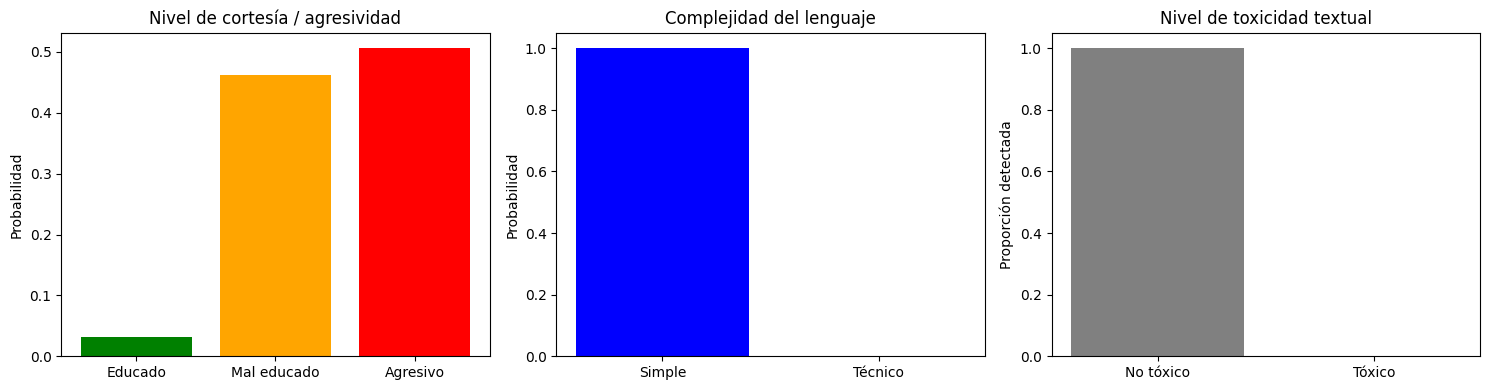

Palabras educadas detectadas: []
Palabras groseras detectadas: ['desgraciado', 'pendejo']
Nivel de toxicidad (diccionario): {'No tóxico': 1.0, 'Tóxico': 0.0}
Tono del Texto: {'nivel': 'Muy ofensivo', 'probabilidad': 0.79}


In [16]:
result = communication_style_pipeline(text)